In [13]:
### Loading required modules

import numpy as np
import tensorflow as tf
import os,sys
import datetime
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import cv2
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from tensorflow.keras.applications import VGG16,ResNet50V2,DenseNet201,InceptionV3,InceptionResNetV2,NASNetLarge,NASNetMobile,MobileNetV2

tf.config.list_physical_devices('GPU')

#path="/home/ubuntu/pediatric_dental_age_prediction/raw/"
path="/home/ubuntu/pediatric_dental_age_prediction/mask/"

print("Loaded all modules")

Loaded all modules


In [14]:
### loading the model

import pickle

## Direct loading
#modelName = "cnn-fcl-direct.loss_mse.lr_0.001.optimizer_Adam.epoch_200.batch_8.conv-4-8-16-32-64_dropout-0.25_bn-True_actFx-relu.fcl-16_dropout-0.5_bn-True_actFx-relu.time_1113_0829.keras"
modelName= "cnn-fcl-direct.predMask_bin.loss_mse.lr_0.001.optimizer_Adam.epoch_200.batch_8.conv-4-8-16-32-64_dropout-0.25_bn-True_actFx-relu.fcl-16_dropout-0.5_bn-True_actFx-relu.time_1113_0536.keras"
modelNameFull = path+"model/"+modelName
evalDicName = modelNameFull.replace("/model","/eval").replace(".keras", ".eval") 
loadedEvalDic = pickle.load(open(evalDicName, "rb"))
print("Evaluation data fully loaded")

Evaluation data fully loaded


In [15]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf

evalDic={}

Y_pred = loadedEvalDic["pred"]
Y_gold = loadedEvalDic["gold"]

rmse_val = mean_squared_error(Y_gold, Y_pred, squared=False)
loadedEvalDic["rmse"] = rmse_val

print("Evaluation done")

print("Mean absolute error: {0}".format(loadedEvalDic["mae"]))
print("Root Mean-squared error: {0}".format(loadedEvalDic["rmse"]))
print("R2: {0}".format(loadedEvalDic["r2"]))

Evaluation done
Mean absolute error: 0.6197375440597535
Root Mean-squared error: 0.7381082267757527
R2: 0.7307394953373743


5.5231047
9.715601


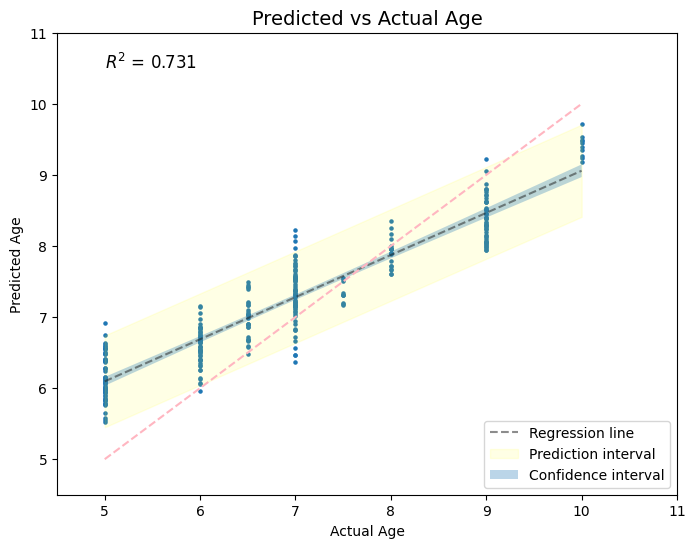

In [16]:
### Performing OLS and plotting the data with prediction values

import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd

minAge = 4.5
maxAge = 11.0

df = pd.DataFrame(zip(loadedEvalDic["gold"].reshape(-1,), loadedEvalDic["pred"].reshape(-1,)))
df.columns = ['gold', 'pred']
print(np.min(df["pred"]))
print(np.max(df["pred"]))

df = df.sort_values(by="gold")

plt.figure(figsize=(8,6))
plt.title("Predicted vs Actual Age", fontsize="14")
plt.scatter(df["gold"], df["pred"],  marker='o', color='#1f77b4', s=5)
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')

model = smf.ols('pred ~ gold', df)


results = model.fit()
alpha = .05
predictions = results.get_prediction(df).summary_frame(alpha)

plt.plot(df["gold"], predictions['mean'], alpha=.5, label='Regression line',color="0.1", linestyle='dashed')
plt.fill_between(df["gold"], predictions['obs_ci_lower'], predictions['obs_ci_upper'], label='Prediction interval', color="yellow", alpha=0.1)
plt.fill_between(df["gold"], predictions['mean_ci_lower'], predictions['mean_ci_upper'], alpha=.3, label='Confidence interval')

# Add y=x line
x = np.arange(np.min(df["gold"]),np.max(df["gold"])+1)
y = x
plt.plot(y, x, color="lightpink", linestyle='dashed')

# Add R square value
plt.text(5, 10.5, '$R^2$ = %.3f'%loadedEvalDic["r2"], size=12)
plt.xlim(minAge,maxAge)
plt.ylim(minAge,maxAge)

plt.legend(loc=4)
plt.show()

#plt.savefig("Predicted_vs_Actual_Age.png", format="png")